# Parkinson Disease Detection

In [20]:
! git clone https://github.com/eladshoham1/Parkinson_Disease_Detection.git

fatal: destination path 'Parkinson_Disease_Detection' already exists and is not an empty directory.


### Imports and Definitions

In [21]:
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

### Loading Dataset

In [22]:
train = np.load('/content/Parkinson_Disease_Detection/Convolutional Neural Network/dataset/train_dataset.npz', allow_pickle=True)
train_x, train_y  = train['arr_0'], train['arr_1']

test = np.load('/content/Parkinson_Disease_Detection/Convolutional Neural Network/dataset/test_dataset.npz', allow_pickle=True)
test_x, test_y = test['arr_0'], test['arr_1']

### Data Distribution

Text(0.5, 1.0, 'Test')

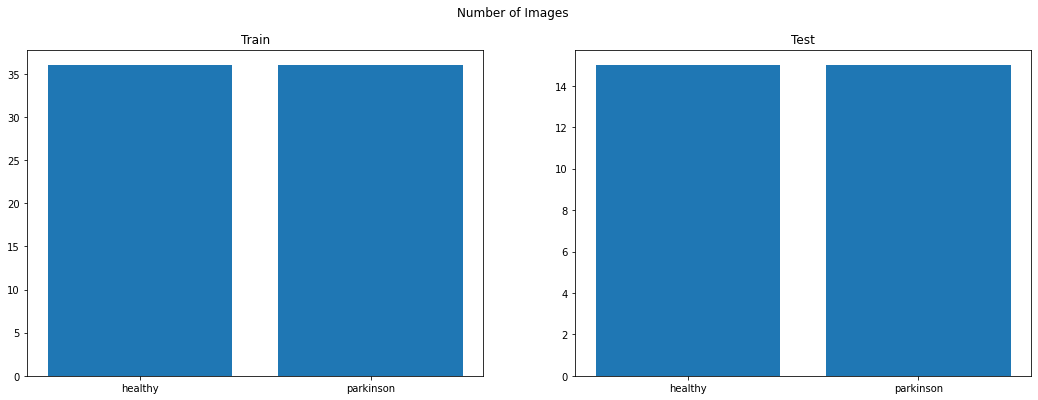

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Number of Images')
unique_train, count_train = np.unique(train_y, return_counts=True)
ax1.bar(unique_train, count_train)
ax1.set_title('Train')
unique_test, count_test = np.unique(test_y, return_counts=True)
ax2.bar(unique_test, count_test)
ax2.set_title('Test')

### Augmenting the Dataset

In [24]:
def dataset_augmenting(data_x, data_y, iter):
  data_generator = ImageDataGenerator(rotation_range=360, width_shift_range=0.0, height_shift_range=0.0, horizontal_flip=True, vertical_flip=True)
  x = list(data_x)
  y = list(data_y)
  aug_data_x = []
  aug_data_y = []
  for i, v in enumerate(y):
      img_x = x[i]
      img_x = np.array(img_x)
      img_x = np.expand_dims(img_x, axis=0)
      aug_iter = data_generator.flow(img_x, batch_size=1, shuffle=True)
      for j in range(iter):
          aug_image = next(aug_iter)[0].astype('uint8')
          aug_data_x.append(aug_image)
          aug_data_y.append(v)
  data_x = x + aug_data_x
  data_y = y + aug_data_y
  return data_x, data_y

In [25]:
train_x, train_y = dataset_augmenting(train_x, train_y, 70)
test_x, test_y = dataset_augmenting(test_x, test_y, 20)

### Images from the dataset

(-0.5, 255.5, 255.5, -0.5)

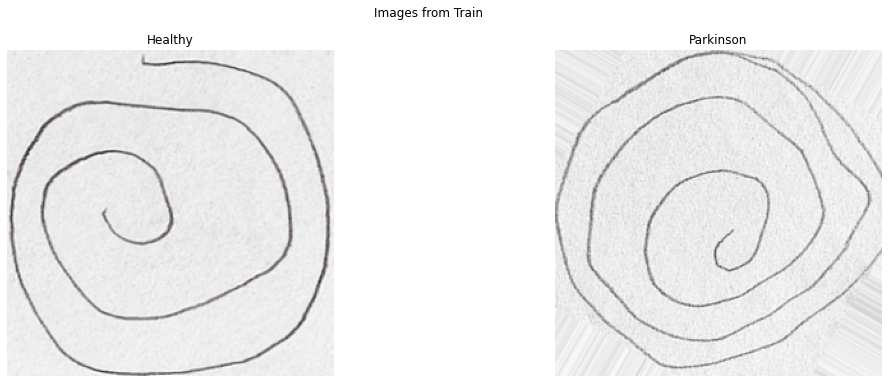

In [26]:
idx_healthy_train = [i for (i, v) in enumerate(train_y) if v=='healthy']
img_healthy_train = train_x[idx_healthy_train[-1]]
idx_parkinson_train = [i for (i, v) in enumerate(train_y) if v=='parkinson']
img_parkinson_train = train_x[idx_parkinson_train[-1]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Images from Train')
ax1.imshow(img_healthy_train)
ax1.set_title('Healthy')
ax1.axis('off')
ax2.imshow(img_parkinson_train)
ax2.set_title('Parkinson')
ax2.axis('off')

(-0.5, 255.5, 255.5, -0.5)

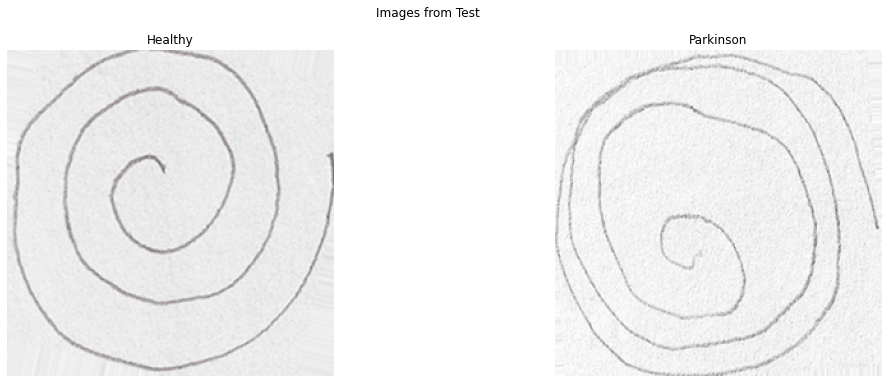

In [27]:
idx_healthy_test = [i for (i, v) in enumerate(test_y) if v=='healthy']
img_healthy_test = test_x[idx_healthy_test[-1]]
idx_parkinson_test = [i for (i, v) in enumerate(test_y) if v=='parkinson']
img_parkinson_test = test_x[idx_parkinson_test[-1]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Images from Test')
ax1.imshow(img_healthy_test)
ax1.set_title('Healthy')
ax1.axis('off')
ax2.imshow(img_parkinson_test)
ax2.set_title('Parkinson')
ax2.axis('off')

### Preprocessing the Images

In [28]:
for i in range(len(train_x)):
    img = train_x[i]
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    train_x[i] = img
    
for i in range(len(test_x)):
    img = test_x[i]
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    test_x[i] = img

train_x = np.array(train_x)
test_x = np.array(test_x)

train_x = train_x / 255.0
test_x = test_x / 255.0

label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_y)
print(train_y.shape)

label_encoder = LabelEncoder()
test_y = label_encoder.fit_transform(test_y)
print(test_y.shape)

(5112,)
(630,)


### Data Distribution after Augmentation

Text(0.5, 1.0, 'Test')

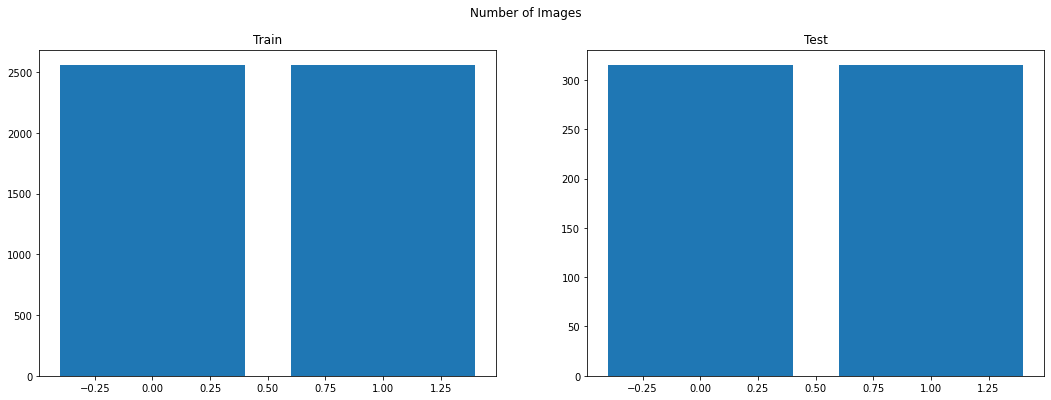

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Number of Images')
unique_train, count_train = np.unique(train_y, return_counts=True)
ax1.bar(unique_train, count_train)
ax1.set_title('Train')
unique_test, count_test = np.unique(test_y, return_counts=True)
ax2.bar(unique_test, count_test)
ax2.set_title('Test')

In [30]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)
train_x = np.expand_dims(train_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)

### Defining the Model

In [31]:
def parkinson_disease_detection_model(input_shape=(128, 128, 1)):
    regularizer = tf.keras.regularizers.l2(0.001)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(128, (5, 5), padding='same', strides=(1, 1), name='conv1', activation='relu', 
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((9, 9), strides=(3, 3)))

    model.add(Conv2D(64, (5, 5), padding='same', strides=(1, 1), name='conv2', activation='relu', 
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((7, 7), strides=(3, 3)))
    
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu', 
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((5, 5), strides=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu', 
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((3, 3), strides=(2, 2)))    
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_initializer='glorot_uniform', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer='glorot_uniform', name='fc3'))
    
    optimizer = Adam(3.15e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [32]:
model= parkinson_disease_detection_model(input_shape=(128, 128, 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 128, 128, 128)     3328      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 128)      0         
 2D)                                                             
                                                                 
 conv2 (Conv2D)              (None, 40, 40, 64)        204864    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 32)        

### Training the Model

In [33]:
history = model.fit(train_x, train_y, batch_size=128, epochs=70, validation_data=(test_x, test_y))

Epoch 1/70
40/40 [==============================] - 7s 146ms/step - loss: 0.8533 - accuracy: 0.4914 - val_loss: 0.8471 - val_accuracy: 0.5000
Epoch 2/70
40/40 [==============================] - 6s 139ms/step - loss: 0.8444 - accuracy: 0.4920 - val_loss: 0.8398 - val_accuracy: 0.5270
Epoch 3/70
40/40 [==============================] - 6s 139ms/step - loss: 0.8368 - accuracy: 0.5063 - val_loss: 0.8328 - val_accuracy: 0.7143
Epoch 4/70
40/40 [==============================] - 6s 141ms/step - loss: 0.8302 - accuracy: 0.5096 - val_loss: 0.8268 - val_accuracy: 0.5000
Epoch 5/70
40/40 [==============================] - 6s 141ms/step - loss: 0.8243 - accuracy: 0.5023 - val_loss: 0.8214 - val_accuracy: 0.5000
Epoch 6/70
40/40 [==============================] - 6s 141ms/step - loss: 0.8191 - accuracy: 0.4955 - val_loss: 0.8158 - val_accuracy: 0.5000
Epoch 7/70
40/40 [==============================] - 6s 142ms/step - loss: 0.8138 - accuracy: 0.5035 - val_loss: 0.8103 - val_accuracy: 0.5000
Epoch 

### Model Accuracy

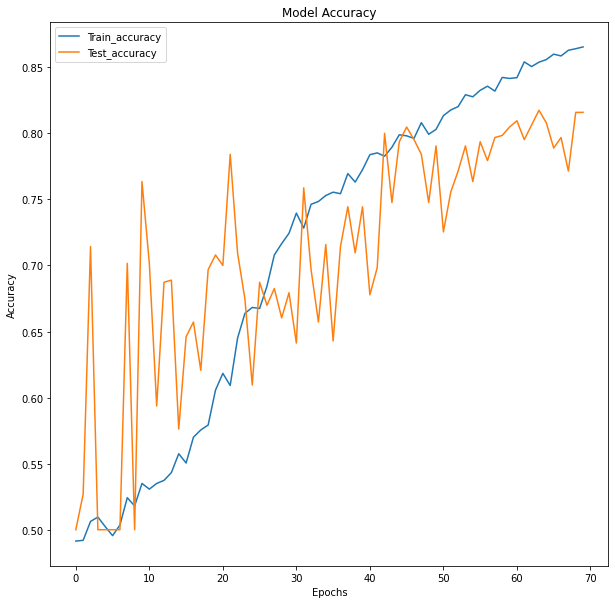

In [34]:
figure = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'], label='Train_accuracy')
plt.plot(history.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

### Model Loss

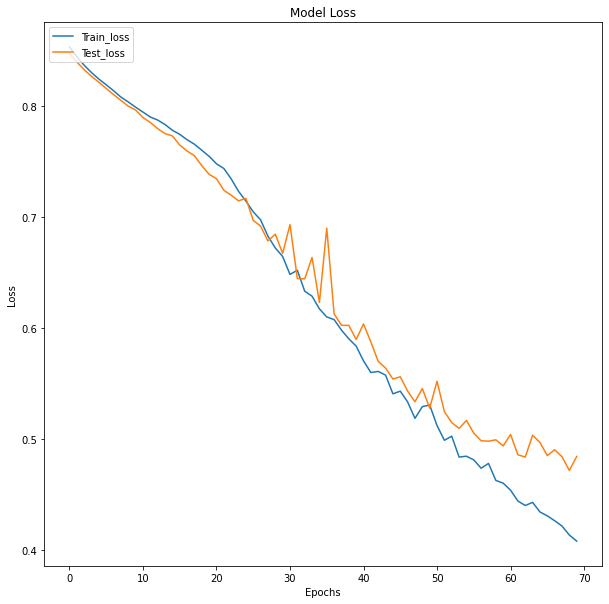

In [35]:
figure2 = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

### Classification Report

In [36]:
ypred = model.predict(test_x)
ypred = np.argmax(ypred, axis=1)
test_pred_y = np.argmax(test_y, axis=1)
print(classification_report(test_pred_y, ypred))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80       315
           1       0.78      0.88      0.83       315

    accuracy                           0.82       630
   macro avg       0.82      0.82      0.82       630
weighted avg       0.82      0.82      0.82       630



### Confusion Matrix

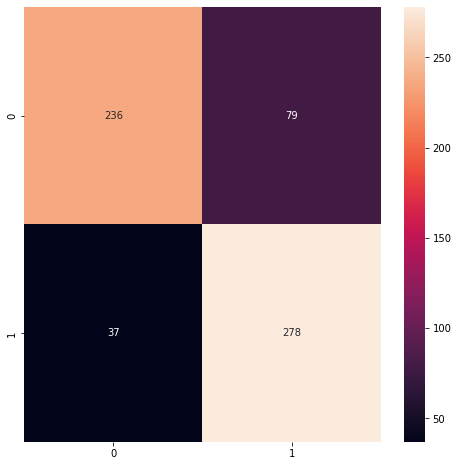

In [37]:
matrix = confusion_matrix(test_pred_y, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(8, 8))
sns.heatmap(df_cm, annot=True, fmt='d')

### Saving the Model

In [38]:
model.save('parkinson_disease_detection_model.h5')